# Move to the directory

In [1]:
%cd ./drive/My\ Drive/perso/CNN_Pneumonia_Finder

/content/drive/My Drive/perso/CNN_Pneumonia_Finder


# Import all the libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import tqdm
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline

# Fetch + Visualize data

Set global variables

In [72]:
NORMAL = 0
PNEUMONIA = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("The code will run in {}".format(device))

The code will run in cuda


In [0]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("./data/train", transform = transformations)
test_set = datasets.ImageFolder("./data/test", transform = transformations)
val_set = datasets.ImageFolder("./data/val", transform = transformations)

num_workers = 4
pin_memory = True if device == 'cuda' else 'cpu'
shuffle = True
batch_size = 32

train_loader = DataLoader(train_set, batch_size=32, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=32, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=32, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)

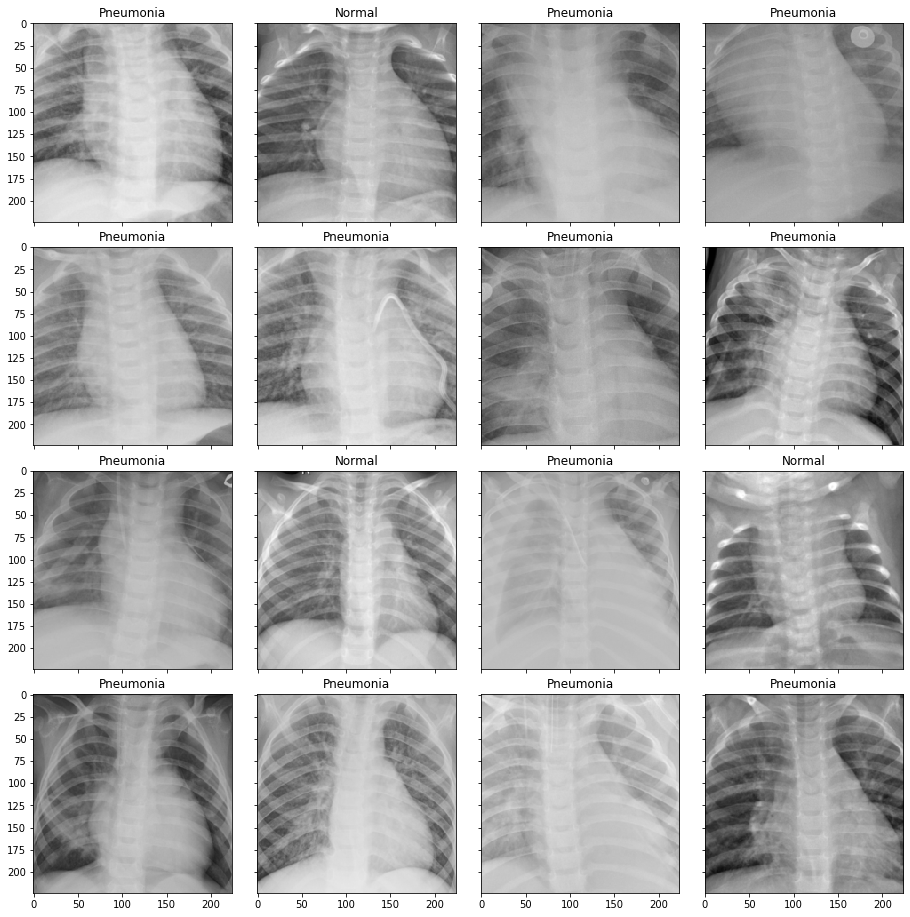

In [97]:
X, y = next(iter(train_loader))

#  Show the data then stops
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.35,  # pad between axes in inch.
                 )

for ax, im, lb in zip(grid, X, y):
  # Iterating over the grid returns the Axes.
  ax.imshow(im.permute(1, 2, 0))
  ax.set_title("Pneumonia" if lb.item() == PNEUMONIA else "Normal")

plt.axis("off")
plt.ioff()
plt.show()

In [0]:
def compute_nb_class(dataset):
  """
  function that computes and returns the number of normal and pneumonia class in the dataset
  args :
      - dataset : dataset to parse
  return :
      - nb_normal : number of element in the normal class
      - nb_pneumonia : number of element in the pneumonia class
  """
  nb_normal = 0
  nb_pneumonia = 0
  for data in dataset:
    for y in data[1]:
      if y == NORMAL:
        nb_normal += 1
      else:
        nb_pneumonia+=1
        
  return nb_normal, nb_pneumonia

this operation could take several times because it loads the data batch by batch for the first time.

<BarContainer object of 1 artists>

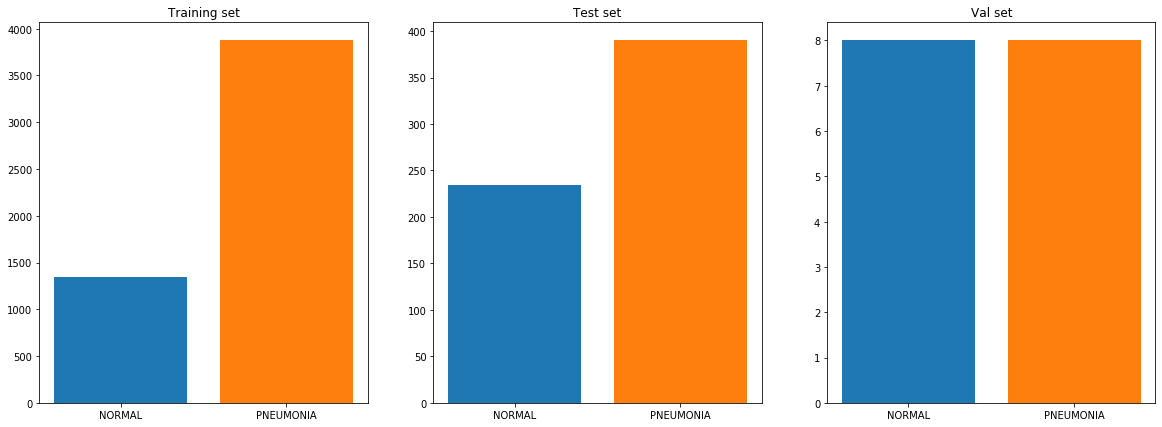

In [37]:
val_nb_normal, val_nb_pneumonia = compute_nb_class(val_loader)
test_nb_normal, test_nb_pneumonia = compute_nb_class(test_loader)
train_nb_normal, train_nb_pneumonia = compute_nb_class(train_loader)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
axes[0].set_title('Training set')
axes[0].bar('NORMAL', train_nb_normal)
axes[0].bar('PNEUMONIA', train_nb_pneumonia)
axes[1].set_title('Test set')
axes[1].bar('NORMAL', test_nb_normal)
axes[1].bar('PNEUMONIA', test_nb_pneumonia)
axes[2].set_title('Val set')
axes[2].bar('NORMAL', val_nb_normal)
axes[2].bar('PNEUMONIA', val_nb_pneumonia)


# Defining model

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.dropout = nn.Dropout(0.3)

    self.conv1 = nn.Conv2d(3, 64, kernel_size=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=2)

    self.conv3 = nn.Conv2d(128, 32, kernel_size=2)

    self.fc1 = nn.Linear( 32 * 27 * 27, 64)

    self.fc2 = nn.Linear(64, 2)

  def forward(self, x):
    x = self.dropout(self.pool(self.conv1(x)))
    x = self.dropout(self.pool(self.conv2(x)))
    x = self.dropout(self.pool(self.conv3(x)))
    x = F.relu(self.fc1(x.view(-1, 32 * 27 *27)))
    return F.softmax(self.fc2(x), dim=-1)

# Train model

In [0]:
MODELS_DIR = "models"
MODEL_NAME = "best_model.pth"
def save_model(model, directory=MODELS_DIR, model_name=MODEL_NAME):
  if not os.path.exists(directory):
      os.makedirs(directory)
  if ".pth" not in model_name:
    model_name += ".pth"
  print("Saving model")
  torch.save(model.state_dict(), os.path.join(directory, model_name))

In [62]:
model = CNN()
model.to(device)
print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(128, 32, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=23328, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [0]:
#GLOBAL PARAM
LOSS = 'loss'
EVAL_PRECISION = 'eval_precision'

#Training parameter
num_epochs = 50
early_stopping_rate = 5
patience = early_stopping_rate
early_stopping_param = LOSS # loss || eval_precision
lr_decay_patience = 2
assert early_stopping_param == LOSS or early_stopping_param == EVAL_PRECISION, "early stopping parameter is not correct, you have to chose it between loss or eval_precision"

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#learning rate optimizer ==> https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min' if early_stopping_param == LOSS else 'max', patience=lr_decay_patience, verbose=True) 

best_early_stopping_param = 0 if early_stopping_param == EVAL_PRECISION else float("inf")

print("Start training :")
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  batch_loss = 0
  print("Starting epoch", epoch+1)
  for i, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    preds = model(X)
    loss = criterion(preds, y.long())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    batch_loss = round(loss.item(), 2)

    if i % 10 == 0: #every 10 batch
      print("loss of the {}'th batch : {}".format(i, batch_loss))
  epoch_loss = round(epoch_loss, 2)
  print("Epoch {}'th loss: {}".format(epoch+1, epoch_loss))
  print()
  print("Evaluation ...")
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    precision = 0
    for X, y in val_loader:
      X = X.to(device)
      y = y.to(device)
      
      outputs = model(X)
      _, predicted = torch.max(outputs.data, 1)
      print("Print prediction :", predicted)
      print("Print groundtruth :", y)
      total += y.size(0)
      correct += (predicted == y).sum().item()

    precision = round((100 * correct / total), 2)
    print('Precision on the validation set: {}'.format(precision))
  print()
  #early_stopping
  if early_stopping_param == LOSS:
    if epoch_loss < best_early_stopping_param:
      best_early_stopping_param = epoch_loss
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  elif early_stopping_param == EVAL_PRECISION:
    if precision > best_early_stopping_param:
      best_early_stopping_aram = precision
      patience = early_stopping_rate
      save_model(model)
    else:
      patience -= 1
  

  print("Early stopping patience : {}".format(patience))

  if patience == 0:
    print("Training stopped due to early stopping.")
    break

  # Note that step should be called after validate()
  scheduler.step(best_early_stopping_param)
  print()


Start training :
Starting epoch 1
loss of the 0'th batch : 0.72
loss of the 10'th batch : 0.51
loss of the 20'th batch : 0.47
loss of the 30'th batch : 0.63
loss of the 40'th batch : 0.44
loss of the 50'th batch : 0.59
loss of the 60'th batch : 0.59
loss of the 70'th batch : 0.56
loss of the 80'th batch : 0.53
loss of the 90'th batch : 0.63
loss of the 100'th batch : 0.72
loss of the 110'th batch : 0.56
loss of the 120'th batch : 0.66
loss of the 130'th batch : 0.5
loss of the 140'th batch : 0.59
loss of the 150'th batch : 0.69
loss of the 160'th batch : 0.5
Epoch 1'th loss: 93.79

Evaluation ...
Print prediction : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Print groundtruth : tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Precision on the validation set: 50.0

Saving model
Early stopping patience : 5

Starting epoch 2
loss of the 0'th batch : 0.47
loss of the 10'th batch : 0.47
loss of the 20'th batch : 0.5
loss of the 30'th ba

# Test the model

In [64]:
model = CNN()
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, MODEL_NAME)))

<All keys matched successfully>

In [105]:
all_preds = torch.tensor([], dtype=torch.long) #used for ploting results
all_gt = torch.tensor([], dtype=torch.long) #used for plotting results
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    all_preds = torch.cat(
            (all_preds, predicted)
            ,dim=0
        )
    all_gt = torch.cat(
            (all_gt, labels)
            ,dim=0
        )
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
precision = round((100 * correct / total), 2)
print('Precision on the test set: {}'.format(precision))

Precision on the test set: 78.04


Plotting some results

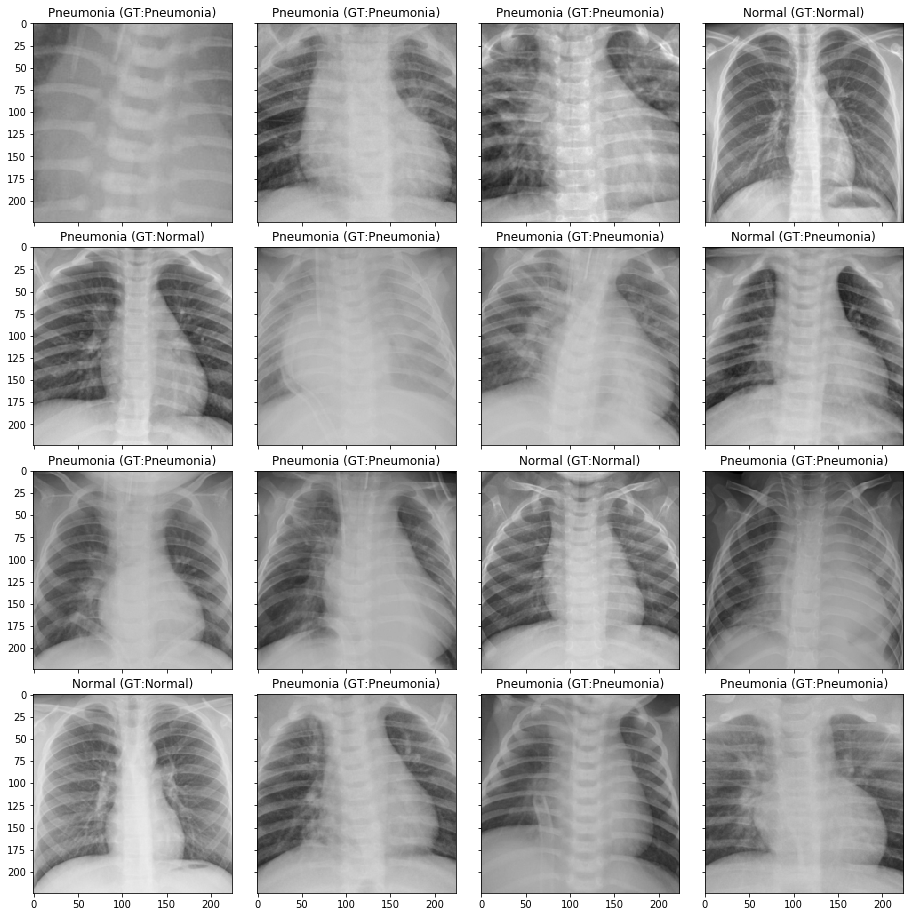

In [107]:
model.eval()
with torch.no_grad():
  X, y = next(iter(test_loader)) 
  #take juste the 16 first
  X = X[0:16]
  y = y[0:16]
  preds_indices = torch.argmax(model(X), -1) #transforms model predictions into indices
  #  Show the data then stops
  fig = plt.figure(figsize=(16, 16))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                  axes_pad=0.35,  # pad between axes in inch.
                  )

  for ax, im, lb, pred in zip(grid, X, y, preds_indices):
    # Iterating over the grid returns the Axes.
    pred = "Pneumonia" if pred == PNEUMONIA else "Normal"
    ax.imshow(im.permute(1, 2, 0))
    ax.set_title("{} (GT:Pneumonia)".format(pred) if lb.item() == 1 else "{} (GT:Normal)".format(pred))

  plt.axis("off")
  plt.ioff()
  plt.show()

In [0]:
#this code is taken from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

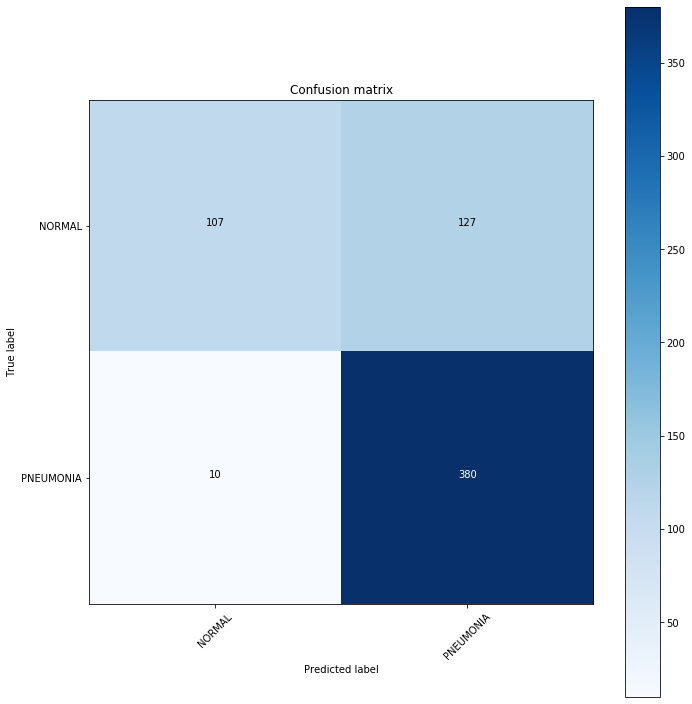

In [118]:
cm = confusion_matrix(all_gt, all_preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['NORMAL', 'PNEUMONIA'])

We can see that our model has some difficulties to predict the Pneumonia, this is of course due to our model, we can highly improve our accuracy by changing the model.